# Walk2D

This example demonstrates global adversarial stress testing and policy analysis in a 2D random walk environment.
- **System under test:** inactive; does nothing to control pawn movement or avoid failure.
- **Failure criterion:** pawn enters circular failure region.
- **Stochastic disturbance:** 2-dimensional pawn movement, normally distributed and uncorrelated.

In this case, the AST problem reduces to a simple goal-seeking reinforcement learning problem. This allows us to easily evaluate the efficacy of the solver and policy analysis.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../..")
Pkg.instantiate()

  Activating environment at `C:\Users\rlipkis\.julia\dev\adastress\examples\walk2d\Project.toml`


In [2]:
using AdaStress
import AdaStress.GrayBox
using Distributions
using Random

## Pawn

In [3]:
Base.@kwdef mutable struct Initialization
    x::Distribution = Uniform(0, 10)
    y::Distribution = Uniform(0, 10)
end

Base.@kwdef mutable struct Pawn
    x::Float64 = 0.0
    y::Float64 = 0.0
end

vec(pawn::Pawn) = [pawn.x, pawn.y]

observation(pawn::Pawn) = vec(pawn) / 10.0 # normalized state

function initialize(pawn::Pawn, init::Initialization)
    pawn.x = rand(init.x)
    pawn.y = rand(init.y)
end

function update(pawn::Pawn, Δx::Float64, Δy::Float64)
    pawn.x += Δx
    pawn.y += Δy
end

update (generic function with 1 method)

## Disturbance and failure models

In [4]:
Base.@kwdef mutable struct Disturbance
	x::Distribution = Normal(0.0, 0.25)
	y::Distribution = Normal(0.0, 0.25)
end

Base.@kwdef mutable struct FailureZone
	x::Float64 = 0.0
	y::Float64 = 0.0
	r::Float64 = 0.0
end

Base.in(pawn::Pawn, zone::FailureZone) = (pawn.x - zone.x)^2 + (pawn.y - zone.y)^2 <= zone.r^2

distance(pawn::Pawn, zone::FailureZone) = max(sqrt((pawn.x - zone.x)^2 + (pawn.y - zone.y)^2) - zone.r, 0.0)

distance (generic function with 1 method)

## Metrics

In [5]:
Base.@kwdef mutable struct Metrics
    d::Float64 = 0.0
	in_zone::Bool = false
end

const Log = Dict{String, Any}

function initialize(m::Metrics, pawn::Pawn, zone::FailureZone)
	update(m, pawn, zone)
end

function update(m::Metrics, pawn::Pawn, zone::FailureZone)
    m.d = distance(pawn, zone) 
	m.in_zone = pawn in zone
end

update (generic function with 2 methods)

## Simulator

In [6]:
Base.@kwdef mutable struct Simulator <: AdaStress.GrayBox
	t::Float64 = 0.0
	t_max::Float64 = 50.0
	pawn::Pawn = Pawn()
	init::Initialization = Initialization()
	disturbance::Disturbance = Disturbance()
	zone::FailureZone = FailureZone(7, 3, 1)
	metrics::Metrics = Metrics()
    env::AdaStress.Environment = AdaStress.Environment()
    log::Log = Log()
    logging::Bool = false
    rand_time::Bool = true
end

function initialize(sim::Simulator)
	sim.t = sim.rand_time ? rand() * sim.t_max : 0.0
	initialize(sim.pawn, sim.init)
	initialize(sim.metrics, sim.pawn, sim.zone)
    sim.env[:Δx] = sim.disturbance.x
    sim.env[:Δy] = sim.disturbance.y
    initialize(sim.log, sim)
    return
end

function update(sim::Simulator, value::AdaStress.EnvironmentValue)
	sim.t += 1.0
	update(sim.pawn, value[:Δx], value[:Δy])
	update(sim.metrics, sim.pawn, sim.zone)
	update(sim.log, sim)
	return
end

update (generic function with 3 methods)

## Logging

In [7]:
function initialize(log::Log, sim::Simulator)
    sim.logging || return
    log["t"] = [sim.t]
    log["pawn"] = [vec(sim.pawn)]
    log["d"] = [sim.metrics.d]
    log["in_zone"] = [sim.metrics.in_zone]
end

function update(log::Log, sim::Simulator)
    sim.logging || return
    push!(log["t"], sim.t)
    push!(log["pawn"], vec(sim.pawn))
    push!(log["d"], sim.metrics.d)
    push!(log["in_zone"], sim.metrics.in_zone)
end

update (generic function with 4 methods)

## Interface setup

In [8]:
Interface.reset!(sim::Simulator) = initialize(sim)

Interface.environment(sim::Simulator) = sim.env

Interface.observe(sim::Simulator) = vcat(observation(sim.pawn), sim.t / sim.t_max)

Interface.step!(sim::Simulator, x::AdaStress.EnvironmentValue) = update(sim, x)

Interface.isterminal(sim::Simulator) = sim.t >= sim.t_max

Interface.isevent(sim::Simulator) = sim.metrics.in_zone

Interface.distance(sim::Simulator) = sim.metrics.d

## Solver

In [9]:
AdaStress.enable("SoftActorCritic")
using AdaStress.SoftActorCritic

┌ Info: Enabled submodule SoftActorCritic.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\AdaStress\src\utils.jl:73


In [10]:
function mdp_env(; kwargs...)
    mdp = Interface.ASTMDP(Simulator(; kwargs...))
    mdp.reward.event_bonus = 100.0
    return mdp
end

mdp_env (generic function with 1 method)

In [11]:
Random.seed!(0)
sac = SAC(;
    obs_dim=3, 
    act_dim=2,
    gamma=0.999,
    act_mins=-3.0*ones(2),
    act_maxs=3.0*ones(2),
    hidden_sizes=[30,30,30],
    num_q=3,
    max_buffer_size=1000000,
    batch_size=1024,
    epochs=25, # low value for testing only; set to >25 to see learning
    steps_per_epoch=1000,
    start_steps=10000,
    max_ep_len=50,
    update_after=10000,
    update_every=1000,
    num_test_episodes=100,
    displays=[(:fails, mdp -> mdp.sim.metrics.in_zone)]
)

SoftActorCritic.ProgressMeter.ijulia_behavior(:clear)
ac, info = sac(mdp_env)

Progress: 100%|█████████████████████████████████████████| Time: 0:06:56
  epoch:  25
  score:  43.305416
  stdev:  1.092561
  fails:  0.55


(MLPActorCritic(SoftActorCritic.SquashedGaussianMLPActor(Chain(Dense(3, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu)), Dense(30, 2), Dense(30, 2), Float32[-3.0, -3.0], Float32[3.0, 3.0], Random._GLOBAL_RNG(), CUDA.CURAND.RNG(Ptr{Nothing} @0x00000000694067d0, CuContext(0x0000000053436e00, instance a73b531b5593f3ec), CuStream(0x0000000069251790, CuContext(0x0000000053436e00, instance a73b531b5593f3ec)), 100)), SoftActorCritic.MLPQFunction[SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1))), SoftActorCritic.MLPQFunction(Chain(Dense(5, 30, relu), Dense(30, 30, relu), Dense(30, 30, relu), Dense(30, 1)))]), Dict{String, Any}("score" => Any[3.803757f0, 4.7551765f0, 3.8326807f0, 2.8032017f0, 7.8311f0, 4.814928f0, 1.8125044f0, 3.810169f0, 0.82042485f0, 4.833205f0  …  11.837438f0, 13.099483f0, 11.209778f0, 15.090101f0,

## Analysis

In [12]:
AdaStress.enable("PolicyValueVerification")
using AdaStress.PolicyValueVerification

┌ Info: Enabled submodule PolicyValueVerification.
└ @ AdaStress C:\Users\rlipkis\.julia\dev\AdaStress\src\utils.jl:73


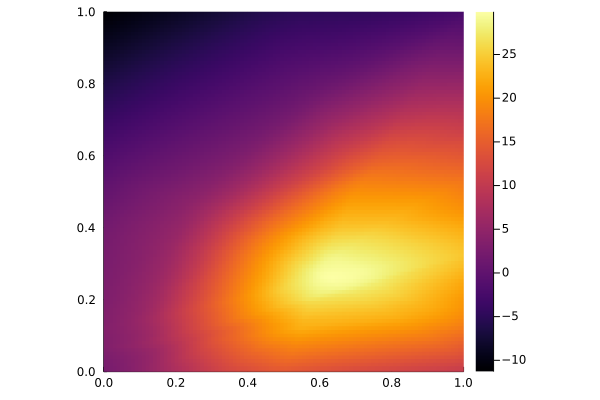

In [13]:
# constructing pseudo-network from the mean of the ensemble
network = mean_network(ac; act_mins=-3*ones(2), act_maxs=3*ones(2));

# holding time constant at t/t_max = 0.9
cs = CrossSection([:x1, :x2, 0.9])
limits = ([0.0, 0.0], [1.0, 1.0])
p = PolicyValueVerification.visualize(network, cs, limits)

In [14]:
# creating cross-section network
nnet = cross_section(network, cs, limits)

# arbitrarily choosing value at center of domain as splitting criterion
midpoint_value = PolicyValueVerification.compute_output(nnet, mean(limits))[];

In [15]:
# binary refinement attempts to prove that value in region lies above or below splitting value
r = BinaryRefinery(network=nnet, val=midpoint_value, tol=0.01)
root = get_root(limits)
@time refine!(root, r)

 21.755093 seconds (104.81 M allocations: 40.360 GiB, 15.08% gc time, 22.29% compilation time)


In [16]:
@show num_leaves(root)      # number of leaves in proof tree
@show coverage(root)        # fraction of leaves proven true or false
@show coverage(root, true)  # fraction of leaves proven true
@show coverage(root, false) # fraction of leaves proven false

num_leaves(root) = 340
coverage(root) = 0.9716796875
coverage(root, true) = 0.590087890625
coverage(root, false) = 0.381591796875


0.381591796875

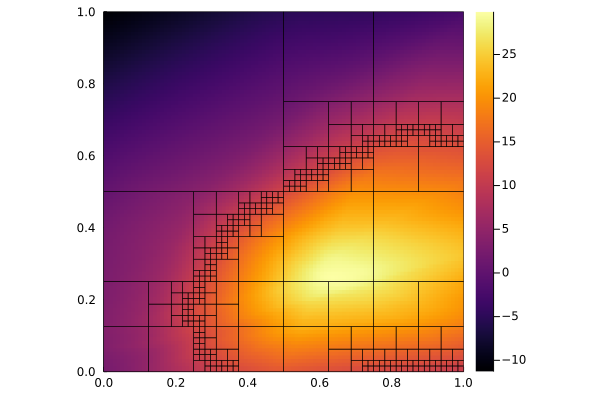

In [17]:
visualize!(deepcopy(p), root)

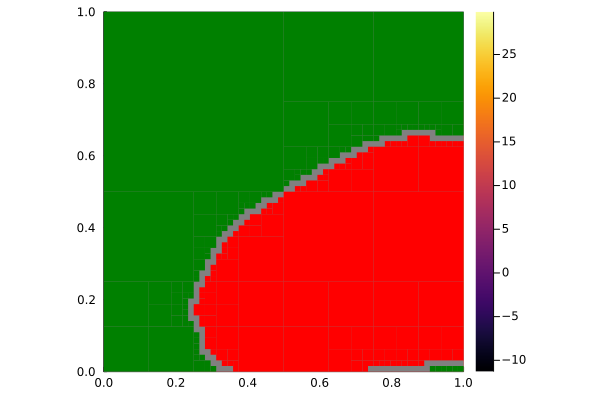

In [18]:
visualize!(deepcopy(p), root; fill=true)